In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lime.lime_tabular import LimeTabularExplainer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import confusion_matrix

# Data Processing

## Encode Categorical Features

In [3]:
data = pd.read_csv(r"../data/train.csv", delimiter=";")
to_encode = data.select_dtypes(include=['object', "category"]).columns
encoder = LabelEncoder()
for _col in to_encode:
    data[_col + "_encode"] = encoder.fit_transform(data[_col])

## Check for Na Values

Its Clean :)

In [4]:
data.isna().sum()

age                 0
job                 0
marital             0
education           0
default             0
balance             0
housing             0
loan                0
contact             0
day                 0
month               0
duration            0
campaign            0
pdays               0
previous            0
poutcome            0
y                   0
job_encode          0
marital_encode      0
education_encode    0
default_encode      0
housing_encode      0
loan_encode         0
contact_encode      0
month_encode        0
poutcome_encode     0
y_encode            0
dtype: int64

# Data Analysis

## Checking for output disparity

Perhaps need to do some random sampling, actually not perhaps, we need to

Methods to use:
   - Oversample
   - SMOTE
   

(array([39922.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  5289.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

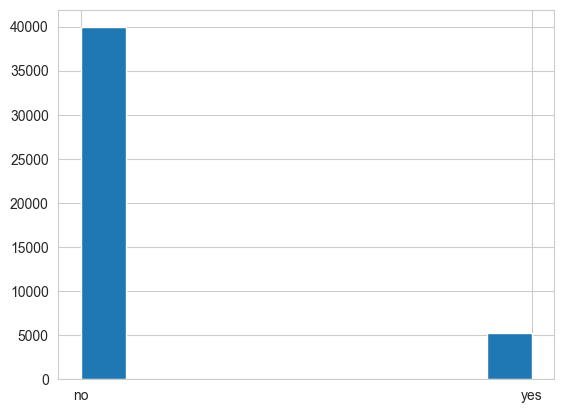

In [5]:
plt.hist(data["y"])

## Check for Pairplot between continuous values

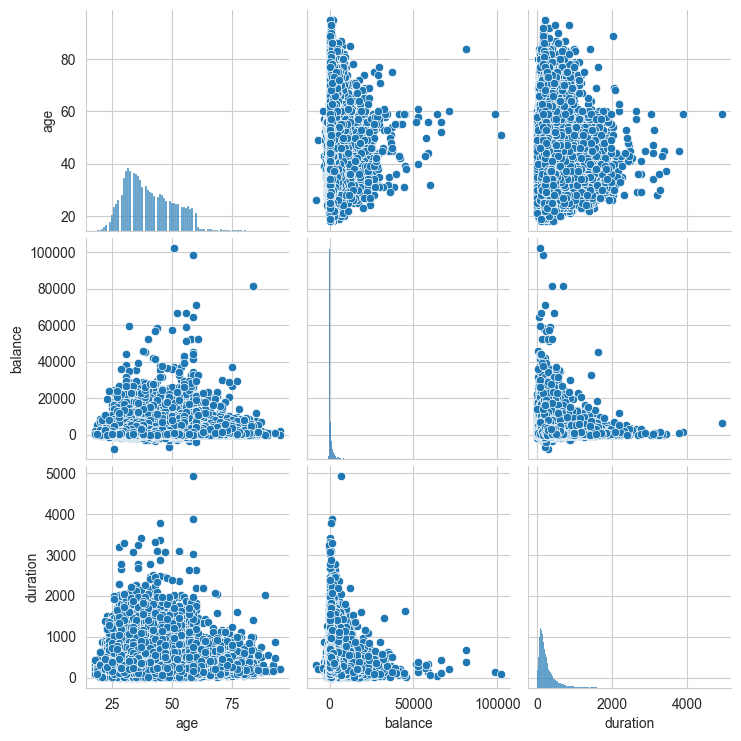

In [6]:
cont_features = [
    "age",
    "balance",
    "duration"
]

sns.pairplot(data[cont_features])
plt.show()

## Check Correlation between all the variables

Need to be observed:
   - Duration with y (R = 0.394) - Can be ignored??

<Axes: >

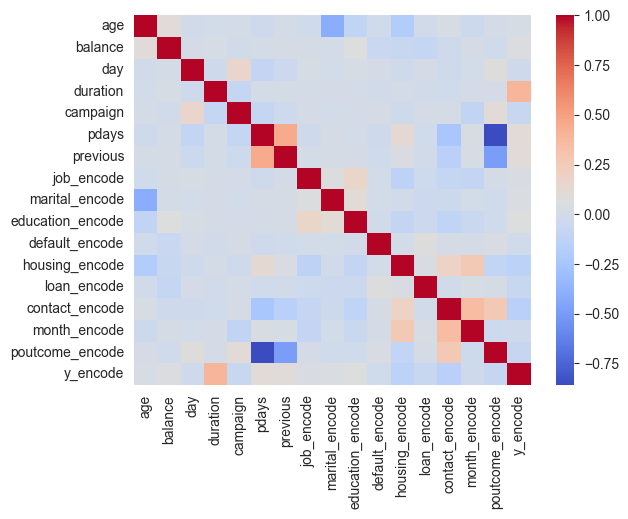

In [7]:
data_corr = data.drop(columns = list(to_encode), errors = "ignore").corr()
sns.heatmap(data_corr, cmap='coolwarm')

In [8]:
data_corr["duration"]["y_encode"]

0.3945210158945639

## Using Lime with Random Forest to check for possible explanation

Steps Taken:
   - Scale
   - SMOTE
   - Random Forest (Not optimized)
   - Lime Explain
   
Most probable cause:
   -   Duration (-ve)
   -   Campaign (-ve)
   -   Balance  (-ve)

In [28]:
data
X = data.drop(columns = list(to_encode) + ["y_encode",], errors = "ignore")
training_features = X.columns
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled.columns = training_features
Y = data["y_encode"]
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=3101)
smote = SMOTE(random_state=3101)
X_resampled, Y_resampled = smote.fit_resample(X_train, Y_train)

In [32]:
model = RandomForestClassifier(class_weight="balanced", random_state=3101)
model.fit(X_resampled, Y_resampled)

RandomForestClassifier(class_weight='balanced', random_state=3101)

In [33]:
explainer = LimeTabularExplainer(X_resampled.values, 
                                 feature_names=training_features, 
                                 class_names=["False", "True"], 
                                 discretize_continuous=True)

# Select an instance from the test set to explain
instance = X_test.iloc[0].values.reshape(1, -1)

# Generate explanation for the selected instance
explanation = explainer.explain_instance(instance[0], model.predict_proba, num_features=10)

# Display explanation in the notebook
explanation.show_in_notebook()

C:\Users\limti\PycharmProjects\DSA3101-Group-20\.labelimge\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [38]:
Y_pred = model.predict(X_test)

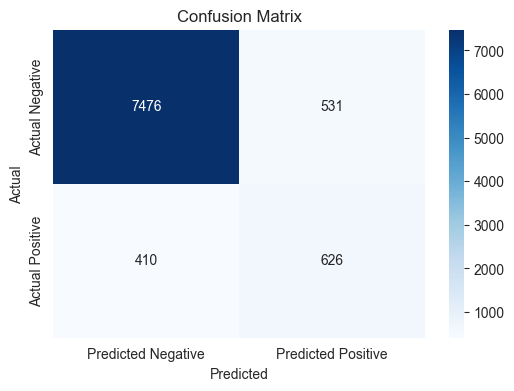

In [42]:
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()